In [1]:
import sys
sys.path.append('..')

import utils, selex_dca, indep_sites
import adabmDCA
import selex_distribution, energy_models, tree, data_loading, training, callback, sampling

import torch
from utils import one_hot
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import sklearn

/Users/scrotti/Aptamer2025py/experiments/../selex_dca.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
dtype = torch.float32

## Generate

In [3]:
tr = tree.Tree()
tr.add_node(-1, name = "round 1 with selection")
tr.add_node(0, name = "round 2 with selection")

selected_modes = torch.BoolTensor(
    [[1],
     [1]]
)

n_selection_rounds, n_modes = selected_modes.size()
assert n_selection_rounds == tr.get_n_nodes()
n_rounds = n_selection_rounds + 1

In [4]:
L, q = 10, 3

In [5]:
def hamming(x:torch.tensor, y: torch.tensor):
    L = x.size(-2)
    return L - (x * y).sum((-2, -1)).to(torch.int)

Pick as wildtype something which is well-aligned with ps

In [6]:
generator = torch.Generator().manual_seed(0)

h_teacher = torch.randn(L, q, dtype=dtype, generator=generator)

wt_oh = sampling.sample_indep_sites(h_teacher, n_samples=1, generator=generator, beta=7.0).squeeze()
torch.nn.functional.cosine_similarity(wt_oh, h_teacher.exp()).mean()

tensor(0.8363)

In [7]:
mutation_rate = 0.2
k_teacher = utils.field_from_wildtype(wt_oh, mutation_rate)
J_teacher = utils.rand_coupling_matrix(L, q, dtype=dtype)

Ns0_teacher = energy_models.IndepSites(k_teacher)
# ps_teacher = selex_distribution.MultiModeDistribution(energy_models.IndepSites(h_teacher), normalized=False)
ps_teacher = selex_distribution.MultiModeDistribution(energy_models.Potts(J_teacher, h_teacher), normalized=False)
model_teacher = selex_distribution.MultiRoundDistribution(Ns0_teacher, ps_teacher, tr, selected_modes)
model_teacher.train(mode=False);

In [8]:
n_chains = 10**5
chains_teacher = training.init_chains(n_rounds, n_chains, L, q, dtype=dtype)

In [9]:
n_sweeps = 30
energies = model_teacher.sample(chains_teacher, n_sweeps)

In [10]:
sequences_oh = chains_teacher
total_reads = total_reads = torch.Tensor([sequences_oh.shape[1] for _ in range(n_rounds)])

## Learn

In [11]:
k = torch.zeros(L, q, dtype=dtype)
h = torch.zeros(L, q, dtype=dtype)
J = torch.zeros(L, q, L, q, dtype=dtype)

Ns0 = energy_models.IndepSites(k)
ps = selex_distribution.MultiModeDistribution(energy_models.Potts(J, h), normalized=False)
model = selex_distribution.MultiRoundDistribution(Ns0, ps, tr, selected_modes, learn_selection_strength=False)

In [12]:
batch_size = 10**4
data_loaders = [data_loading.SelexRoundDataLoader(sequences_oh[id], batch_size=batch_size, device=torch.device('cpu')) 
                for id in range(n_rounds)]

In [13]:
n_chains = 10**4
chains = training.init_chains(n_rounds, n_chains, L, q, dtype=dtype)
log_weights = torch.zeros(n_rounds, n_chains, dtype=dtype)

In [14]:
checkpoint_filename = 'test'
checkpoint_every = 10
callbacks = [callback.ConvergenceMetricsCallback(), callback.TeacherStudentCallback(model_teacher), 
             callback.CheckpointCallback(save_every=checkpoint_every, filename=checkpoint_filename),
             callback.PottsParamsCallback(save_every=20)]

In [15]:
n_sweeps = 10
lr = 0.1
max_epochs = 400
checkpoint_filename = 'test'

training.train(model, data_loaders, total_reads, chains, n_sweeps, max_epochs,
               lr=lr, callbacks=callbacks, log_weights=log_weights)

 0.00%[                                   ] Epoch: 0/400 [00:00, ?it/s]

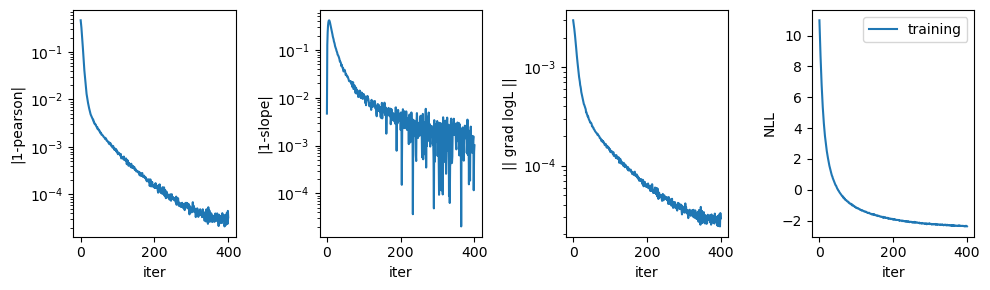

In [16]:
fig, axes = callbacks[0].plot();

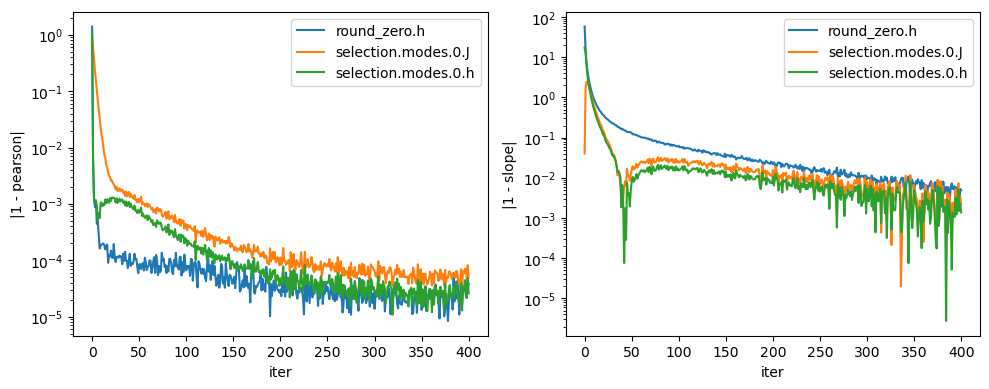

In [17]:
callbacks[0].plot_pearson_detail();

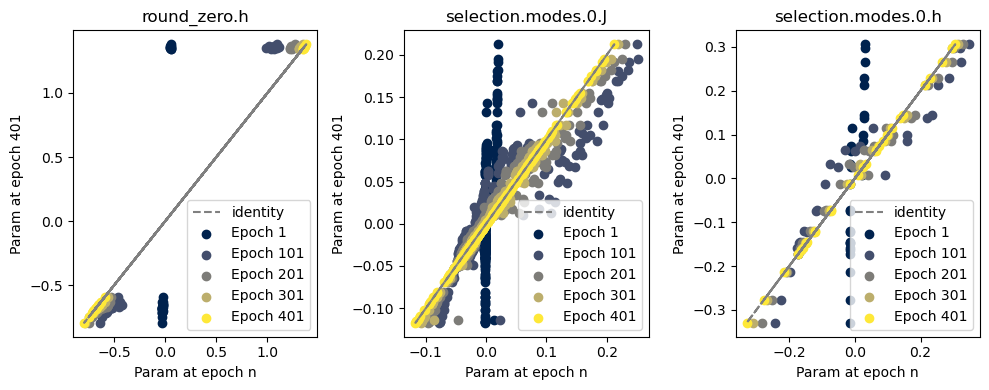

In [28]:
fig, axes = callbacks[-1].plot(plot_every=5);

In [19]:
cps = training.load_checkpoints(checkpoint_filename)
nlls = []

for n in range(len(cps)):
    cp = cps[n]
    model_ = cp['model']
    log_weights_ = cp['log_weights'] 
    batches = [next(iter(dl)) for dl in data_loaders]
    nll = - training.estimate_log_likelihood(model_, batches, total_reads, log_weights_)
    nlls.append(nll)

Loaded 40 files.


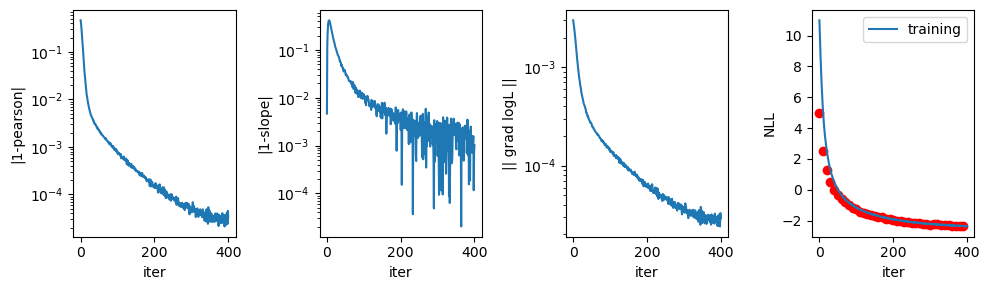

In [26]:
fig, axes = callbacks[0].plot()

ax = axes[3]
ax.scatter(range(0, len(cps)*checkpoint_every, checkpoint_every), nlls, color='r')